# CA02 - Training Perceptron and Adaline models
Tonje Martine Lorgen Kirkholt

Make sure you: a) describe briefly what you intend to do using markdown cells; b) comment your code properly but briefly, such that the reader can easily understand what the code is doing.


## Imports

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing the classifiers
from CA2.classifiers.adaline import AdalineGD
from CA2.classifiers.perceptron import Perceptron

## Loading and exploring data


Visualise the raw data with appropriate plots and inspect it for possible outliers or inconsistencies. Comment briefly on what you see and how this will impact the performance of the perceptron and adaline. For this use no more than three sentences.

In [147]:
# Loading the dataset which will be used throughout this assignmen
wine_data = pd.read_csv('assets/wine.csv')

# Observing how the data looks like in a table
wine_data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,class
0,10.4,0.520,0.45,2.0,0.080,6.0,13.0,0.99774,3.22,0.76,11.4,1
1,7.5,0.570,0.02,2.6,0.077,11.0,35.0,0.99557,3.36,0.62,10.8,1
2,6.6,0.695,0.00,2.1,0.075,12.0,56.0,0.99680,3.49,0.67,9.2,0
3,7.9,0.545,0.06,4.0,0.087,27.0,61.0,0.99650,3.36,0.67,10.7,1
4,8.0,0.180,0.37,0.9,0.049,36.0,109.0,0.99007,2.89,0.44,12.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...
794,7.2,0.620,0.06,2.7,0.077,15.0,85.0,0.99746,3.51,0.54,9.5,0
795,6.9,0.510,0.23,2.0,0.072,13.0,22.0,0.99438,3.40,0.84,11.2,1
796,6.6,0.960,0.00,1.8,0.082,5.0,16.0,0.99360,3.50,0.44,11.9,1
797,8.3,0.650,0.10,2.9,0.089,17.0,40.0,0.99803,3.29,0.55,9.5,0


In [148]:
# Observing a more detailed overview of the data.
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799 entries, 0 to 798
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         799 non-null    float64
 1   volatile acidity      799 non-null    float64
 2   citric acid           799 non-null    float64
 3   residual sugar        799 non-null    float64
 4   chlorides             799 non-null    float64
 5   free sulfur dioxide   799 non-null    float64
 6   total sulfur dioxide  799 non-null    float64
 7   density               799 non-null    float64
 8   pH                    799 non-null    float64
 9   sulphates             799 non-null    float64
 10  alcohol               799 non-null    float64
 11  class                 799 non-null    int64  
dtypes: float64(11), int64(1)
memory usage: 75.0 KB


Looking at a heatmap of the data to observe the existing correlations

<AxesSubplot: >

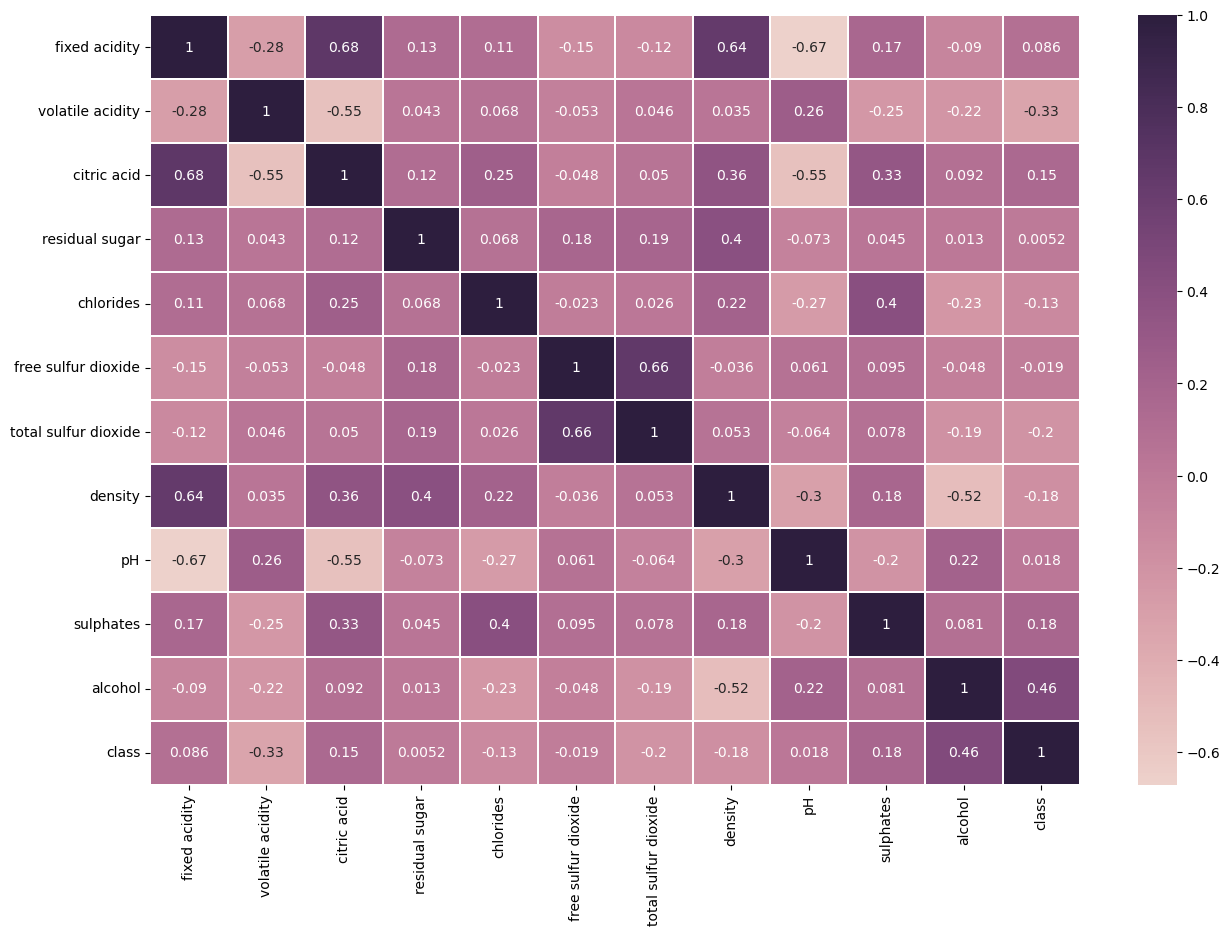

In [149]:
# Plotting a heatmap to observe the existing correlation in the data set.
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(wine_data.corr(), annot=True, linewidth=.3, cmap=sns.cubehelix_palette(as_cmap=True), ax=ax)

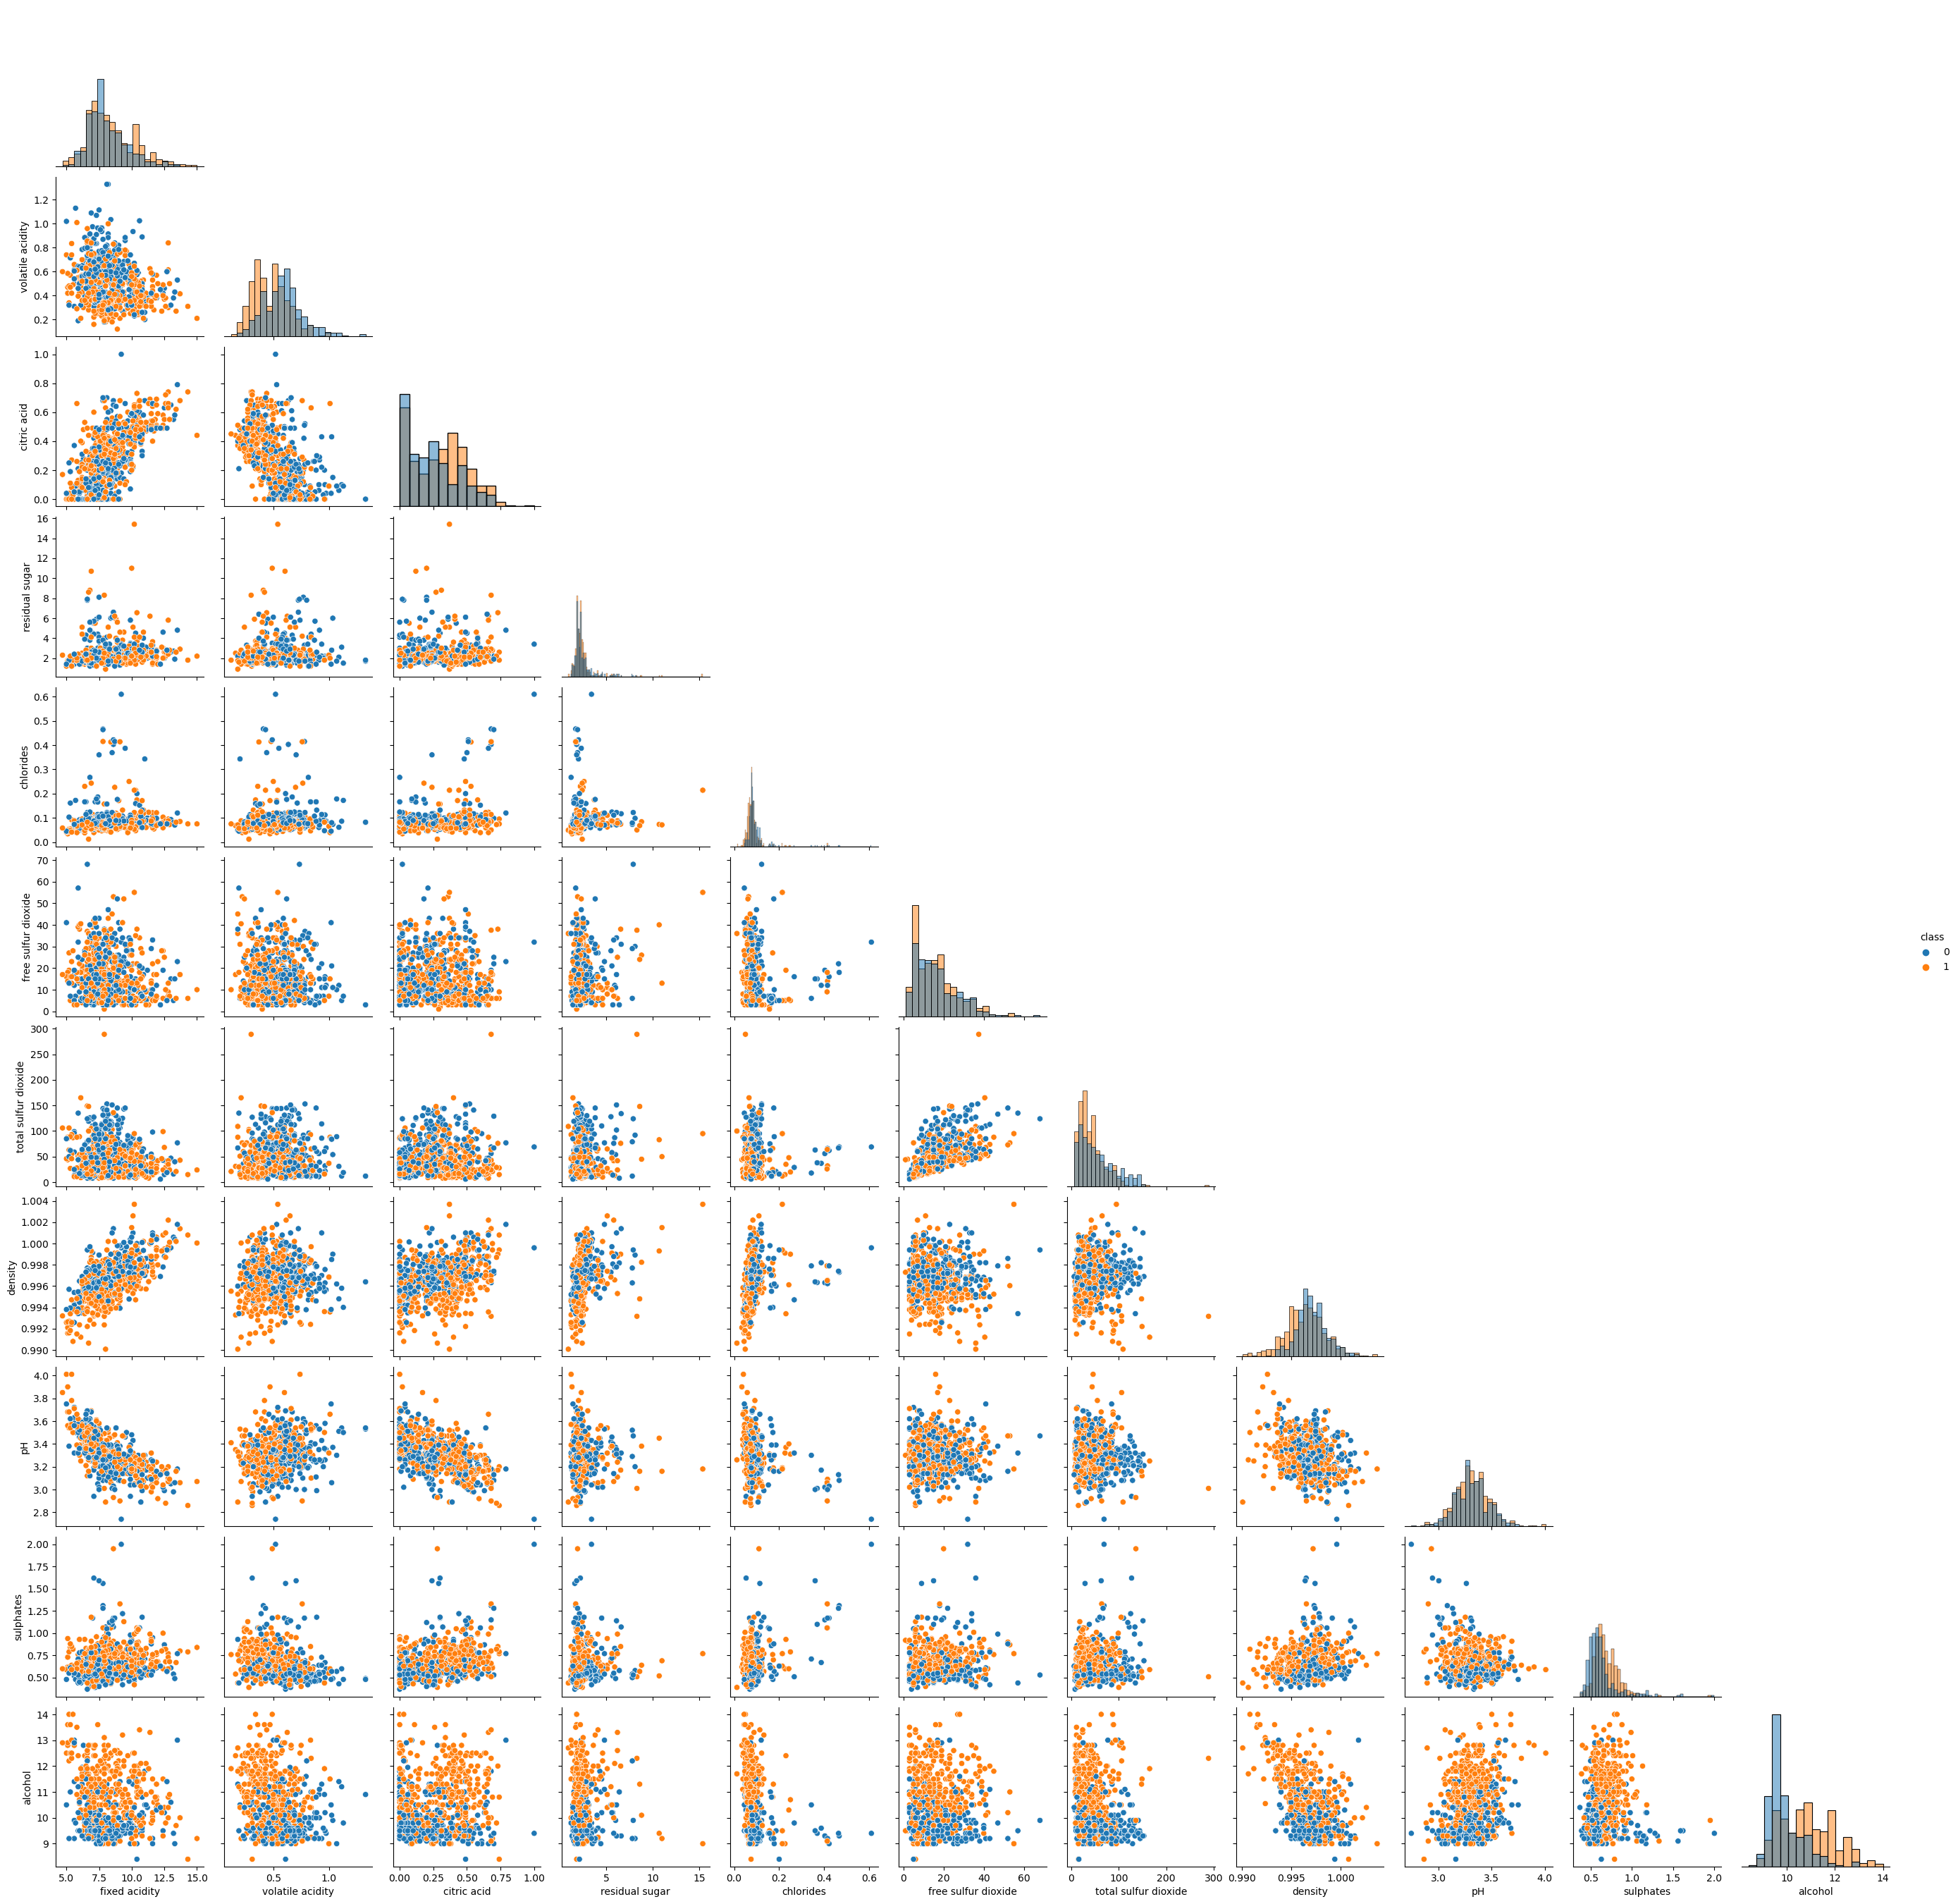

In [150]:
# Making a pariplot, using the class-feature as hue to map the data points. Lets us observe the relationship in the dataset pairwise.
sns.pairplot(wine_data, hue="class", diag_kind="hist", corner=True)

<AxesSubplot: >

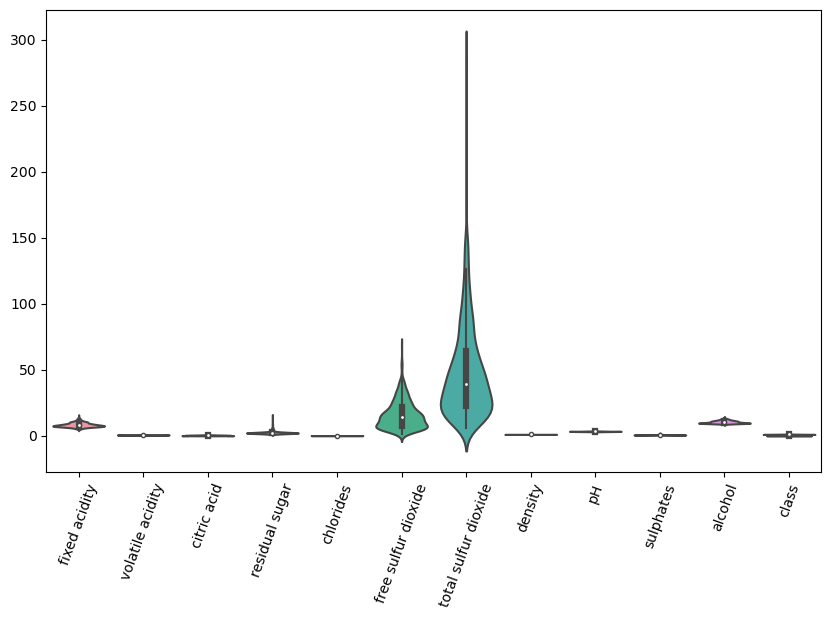

In [151]:
fig, ax = plt.subplots(figsize=(10,6))
plt.xticks(rotation=70)
sns.violinplot(data=wine_data, scale="count")

<AxesSubplot: ylabel='Count'>

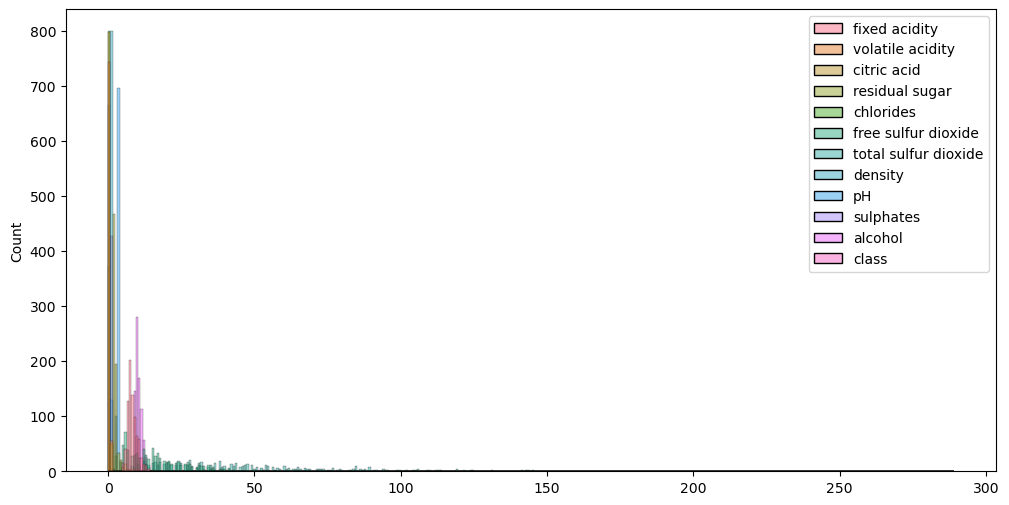

In [152]:
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(data=wine_data, ax=ax)

We observe differences considering the scale of each feature in the violin plot and the histogram. If the distance between the data points are large, this will increase the uncertainty in the prediction done by the model. The values will be scaled through standardization to ensure better predictions.

 In the heatmap, we observe that the highest correlations can be found between **class and alcohol**, **class and sulphates**, and **class and citric acid**.

Comparing the pariplot with the correlation matrix, we see that the features that have the highest correlation are *free sulfur dioxide and total sulfur dioxide*(0.66),*sulphates and chlorides* (0.4), and *density and citric acid*(0.36).

## Preprocessing data and training models

- Split the data into training and test_sets, where 400 samples are used for training
- Make sure the target values are appropriate for the Adaline and Perceptron classifiers

With each of the 400 models, you should predict the classes of the unseen samples in the test data and compute the test set classification accuracy. Store the results in a (8 x 50) numpy array or a pandas dataframe.

__Preprocessing:__

Checking if there are any null values in the data.

In [153]:
wine_data.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
class                   0
dtype: int64

Splitting the data into training and test sets

In [154]:
# Choosing the first 400 values, which means until row 399 since the first row = 0. For training we use all of the columns, for test we use only the last one: class.

X_train = wine_data.loc[:399, wine_data.columns[:10]]
y_train = wine_data.loc[:399, wine_data.columns[11]]

X_test = X_train.copy()
y_test = y_train.copy()

# Converting y-values to [-1, 1]
y_train = np.where(y_train==1, 1, -1)
y_test = np.where(y_test == 1, 1, -1)

Scaling the data through standardization. This will ensure that the data has a mean of 0 and standard deviation of 1 (unit variance).

In [155]:
# Scaling the data by standardizing it
# Using the built-in NumPy methods mean and std

# Making a copy of the X-values from the dataset
X_train_scaled = np.copy(X_train)
X_test_scaled = np.copy(X_test)

# Calculating the mean throughout all the columns
X_train_mean = np.mean(X_train_scaled, axis=0)

# Calculating the standard deviation throughout all the columns
X_train_std = np.std(X_train_scaled, axis=0)

# Standardizing the data by subtracting the mean from the original X-values, and dividing it by the std
X_train_scaled = (X_train_scaled - X_train_mean) / X_train_std
# Test-set is scaled with the calculated mean and std from the training-set
X_test_scaled = (X_test_scaled - X_train_mean) / X_train_std

In [156]:
X_train_std

array([1.57396561e+00, 1.75635060e-01, 2.02257256e-01, 1.18961336e+00,
       5.49781829e-02, 1.00301932e+01, 3.17162025e+01, 1.85927587e-03,
       1.53080338e-01, 1.72117954e-01])

Text(0.5, 1.0, 'Training set for X, post scaling')

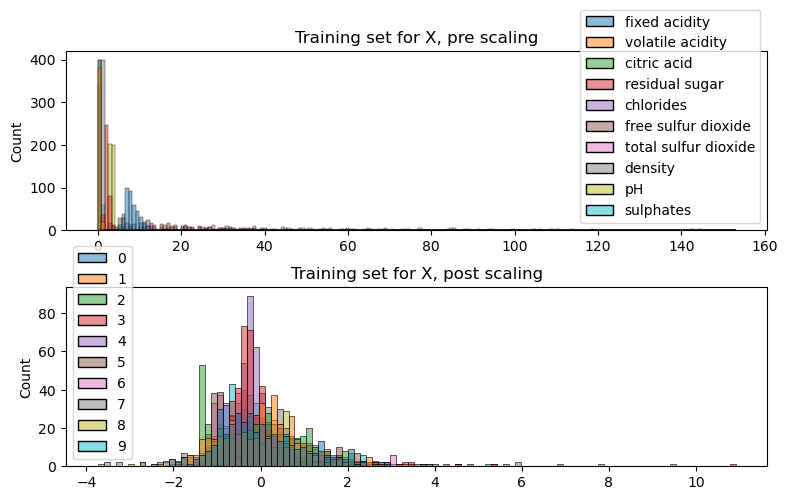

In [157]:
# Plotting all the values in a histogram to look at the distribution, before and after scaling
fig, ax = plt.subplots(2,1, figsize=(8,5))
fig.tight_layout(pad=2)
X_pre_scale = sns.histplot(X_train, ax=ax[0])
ax[0].set_title('Training set for X, pre scaling')
X_post_scale = sns.histplot(X_train_scaled, ax=ax[1])
ax[1].set_title('Training set for X, post scaling')

<AxesSubplot: >

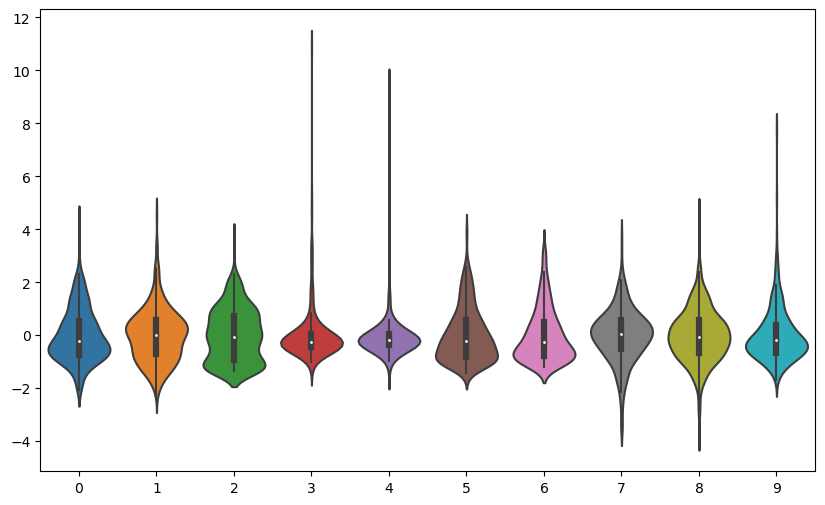

In [158]:
# Compared to the violinplot printed earlier, it is clear that the mean now is more centered around 0
# and that we have a standard deviation of 1
fig, ax = plt.subplots(figsize=(10,6))
sns.violinplot(data=X_train_scaled, scale="count")

__Training:__

In [159]:
# Defining the ground truth, which will be used to compare to the calculated prediction
ground_truth = y_test

# Variables for models, eta and seed
eta = 0.0001
seed = 9

# Defining an empty numpy array, where the requested shape is 8x50
adaline_accuracy = np.empty(shape=(8,50), dtype=float)
perceptron_accuracy = np.copy(adaline_accuracy)

# Defining row in range 50 - 400, with a step-increase of 50 for each iteration
# Using enumerate outside this to coun the total number of iteration
# Using subset and row to add the calculated values to a numpy array
for subset, row in enumerate(range(50, 450, 50)):
    X_subset = X_train_scaled[:row]
    y_subset = y_train[:row]
    for epoch in range(51):
        ada_wine_model = AdalineGD(n_iter=epoch, eta=eta, random_state=seed).fit(X_subset, y_subset)
        perc_wine_model = Perceptron(n_iter=epoch, eta=eta, random_state=seed).fit(X_subset, y_subset)

        # Predicting the wine classes
        y_pred_ada = ada_wine_model.predict(X_test_scaled)
        y_pred_perc = perc_wine_model.predict(X_test_scaled)

        y_accuracy_ada = sum(np.equal(ground_truth, y_pred_ada) / len(ground_truth))
        y_accuracy_perc =  sum(np.equal(ground_truth, y_pred_perc) / len(ground_truth))


        adaline_accuracy[subset, epoch - 1] = y_accuracy_ada
        perceptron_accuracy[subset, epoch-1] = y_accuracy_perc

## Visualizing results

Plot a heatmap of the results (test set classification accuracy) using Python plotting packages matplotlib or seaborn (Lenker til en ekstern side.). See below what the heatmaps should look like for the two classification algorithms.

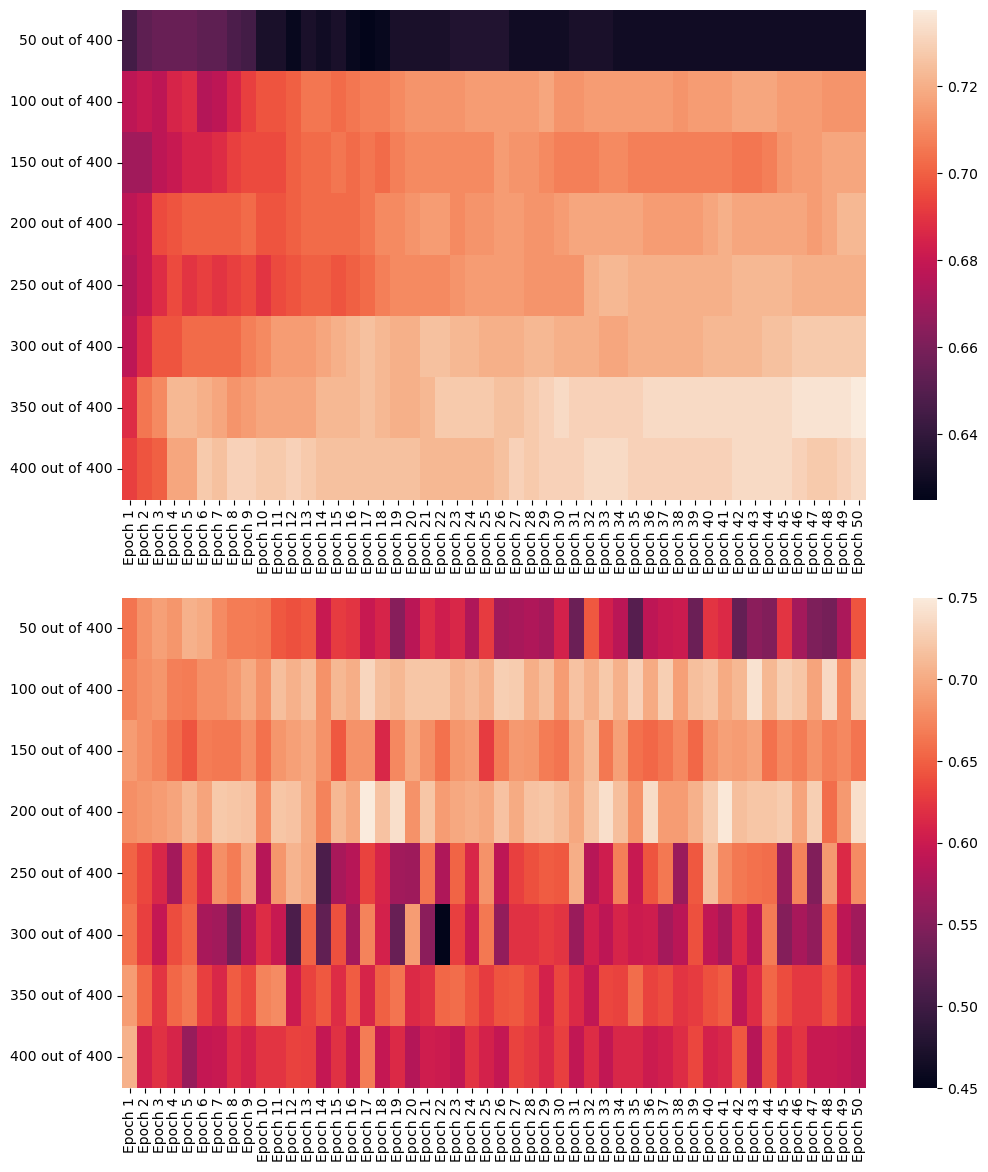

In [160]:
# Creating correct label names for each axis
X_values = [f'Epoch {epoch}' for epoch in range(1, 51)]
y_values = [f'{row} out of 400' for row in range(50, 450, 50)]

# Plotting the heatmaps with the results from both models, separately
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 14))
adaline_heatmap = sns.heatmap(data=adaline_accuracy, xticklabels=X_values, yticklabels=y_values, ax=ax[0])
perceptron_heatmap = sns.heatmap(data=perceptron_accuracy, xticklabels=X_values, yticklabels=y_values, ax=ax[1])
plt.show()


## Metrics

Provide the maximum test set classification accuracy for each, the perceptron classifier and the adaline classifier and information on with which combination of number training data samples and number of epochs the best classification accuracy was achieved. 

In [161]:
ada_max = "{:.2f}".format(adaline_accuracy.max() * 100)
perc_max = "{:.2f}".format(perceptron_accuracy.max() * 100)

# Creating two loops to print out the names for each axis.
for subset, row in enumerate(range(50, 450, 50)):
    if subset == (np.argmax(np.max(adaline_accuracy, axis = 1))):
        print(f"Maximum test set calssification accuracy for Adaline: {ada_max}% \nSubset: {row} out of 400"
        f"\nEpoch: {np.argmax(np.max(adaline_accuracy, axis = 0))+1}")

for subset, row in enumerate(range(50, 450, 50)):
    if subset == (np.argmax(np.max(perceptron_accuracy, axis = 1))):
        print(f"Maximum test set calssification accuracy for Perceptron: {perc_max}% \nSubset: {row} out of 400"
        f"\nEpoch: {np.argmax(np.max(perceptron_accuracy, axis = 0))+1}")


#print(f"Maximum test set calssification accuracy for Adaline: {adaline_accuracy[subset, epoch -1].max()}")
#print(f"Maximum test set calssification accuracy for Perceptron: {perceptron_accuracy.max()}")

Maximum test set calssification accuracy for Adaline: 73.75% 
Subset: 350 out of 400
Epoch: 50
Maximum test set calssification accuracy for Perceptron: 75.00% 
Subset: 200 out of 400
Epoch: 17


## Discussion

The training time of the simpler perceptron algorithm is quite a bit longer than the training time of the adaline algorithm. What might be the reason for this?

Looking at the code for both classifiers, Perceptron and Adaline, we see some difference in the method called *fit* where the weights are being calculated. In the Perceptron algorithm, we have a nested for-loop: first, we define errors = 0. The loop inside updates the weights, by comparing the ground truth to the predicted class values, until the calculated updates are equal to the errors (=0). This is repeated for all samples until they have been correctly classified. And as long as there are errors, the Perceptron model continues to learn.


For the Adaline, there is only one for-loop in the *fit* method. In this loop, the computed predictions for y does not influence the computed error values. Adaline computes the difference between the ground truth and, instead of comparing it to the predicted values only it uses the *continuous* calculated output of the predicted y-variable. , and  Because of this, the Adaline model will continue its learning process even when there are no errors (classification is correct).

Comparing the two models, Adaline will finish the training faster because of the way it learns. The Perceptron will use more time in the training process because it only learns from the errors, when Adaline learns throughout every step of the same process.


---